In [81]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat
import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

/m/home/home5/56/kapoorj1/unix


## Generate Data

[[[-2.56442694  1.44370346]
  [-2.36768563  0.87799767]
  [-2.22961035  0.69789014]
  [-2.11034518  0.64468942]
  [-1.99530475  0.64325024]
  [-1.87794134  0.6679681 ]
  [-1.75450243  0.71016771]
  [-1.62207878  0.76812926]
  [-1.47770972  0.84383794]
  [-1.31781745  0.94214661]
  [-1.13768512  1.07097823]
  [-0.93085345  1.24192107]
  [-0.68844368  1.47017238]
  [-0.39875865  1.77060186]
  [-0.04855175  2.14083548]
  [ 0.37025734  2.5148142 ]
  [ 0.84289949  2.69647615]
  [ 1.31005276  2.42005892]
  [ 1.68292281  1.68282146]
  [ 1.90901255  0.85395126]
  [ 2.0028453   0.23637192]
  [ 2.00825319 -0.14068534]
  [ 1.9615085  -0.36001993]
  [ 1.88381256 -0.49590215]
  [ 1.78570156 -0.59323379]
  [ 1.67163791 -0.67681606]
  [ 1.54267892 -0.76119216]
  [ 1.39771924 -0.85670902]
  [ 1.23390086 -0.97301776]
  [ 1.04652456 -1.12129429]
  [ 0.82863908 -1.3155911 ]
  [ 0.57053078 -1.5721991 ]
  [ 0.25981651 -1.90225389]
  [-0.1156804  -2.28533697]
  [-0.55740541 -2.61033847]
  [-1.03458203 -2.63

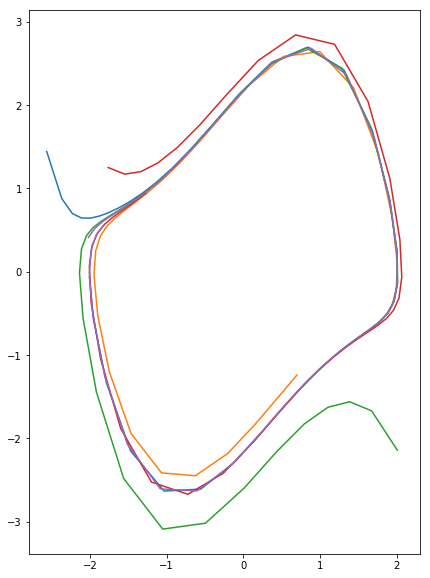

In [82]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
print(X)
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Create Model

In [125]:

# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
# sf  = 1
# ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
# U0 = 0.1*torch.randn(M*M, D)
# # U0 = VDP().forward(0,Zt)

# # # gradient matching
# F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class NN(torch.nn.Module):
    def __init__(self, input_size, hidden_size=10):
        super(NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ELU(),
            nn.Linear(int(hidden_size*1.0), int(hidden_size*1.0)),
            nn.ELU(),
            nn.Linear(hidden_size, input_size)
            )
        
    def forward(self, t, x):
        size = x.size()
        x = x.view(-1)
        x = self.layers(x)
        x = x.view(size)
        return x
        
        
net = NN(input_size=D, hidden_size=20)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, a=-0.5, b=0.5)

net.apply(init_normal)


NN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

### Optimize

In [126]:
params = net.parameters()

# optimizer = optim.Adam(params, lr=5e-3)
# optimizer = optim.SGD(params, lr=1e-4, momentum=0.5, nesterov=True)
optimizer = optim.LBFGS(params, lr=5e-3)
# optimizer = optim.RMSprop(params, lr=1e-3)
reg=0.5

#### Updates: Adam works perfectly ######
#### Momentum + SGD works perfectly for a good lr+mom scheduling ########
#### RMSprop doesnt work for a fixed learning rate (doesnt converge in time) #######
#### RMSprop with momentum converges fast and works perfectly ##############
#### L-BFGS converges with an lr scheduler ##############
####################################################################################

# Incremental Sequence Learning


itr = 0

def closure(use_backward=True, add_prior=True):
    global itr
    T   = min(3+itr//5, len(t))
#     T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    optimizer.zero_grad()
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in params])
    if use_backward:
        loss.backward()
    return loss
    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling
lr = 5e-3
lr_decay=0.1

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for i in range(n_iters):
    for g in optimizer.param_groups:
        g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)
    optimizer.step(closure)
#     lbfgs.step(closure)
    with torch.no_grad():
#         xode = odeint(net, x0, t, method='rk4').permute([1,0,2])
        loss = closure(use_backward=False, add_prior=False)
        if torch.isnan(loss):
            %notify -m "Nan encountered in loss"
            break
        print("Iteration {:04d} | Loss {:.6f}".format(i, loss.item()))
    

Iteration 0000 | Loss 30.046714
Iteration 0001 | Loss 76.356005
Iteration 0002 | Loss 194.088882
Iteration 0003 | Loss 315.033168
Iteration 0004 | Loss 400.437449
Iteration 0005 | Loss 611.419029
Iteration 0006 | Loss 742.549843
Iteration 0007 | Loss 900.187469
Iteration 0008 | Loss 808.417808
Iteration 0009 | Loss 669.479970
Iteration 0010 | Loss 609.942592
Iteration 0011 | Loss 562.369486
Iteration 0012 | Loss 513.170154
Iteration 0013 | Loss 470.144423
Iteration 0014 | Loss 437.421075
Iteration 0015 | Loss 411.353055
Iteration 0016 | Loss 389.222787
Iteration 0017 | Loss 369.955764
Iteration 0018 | Loss 349.311129
Iteration 0019 | Loss 328.035806
Iteration 0020 | Loss 311.980942
Iteration 0021 | Loss 297.904692
Iteration 0022 | Loss 281.949528
Iteration 0023 | Loss 266.667786
Iteration 0024 | Loss 256.631301
Iteration 0025 | Loss 246.270641
Iteration 0026 | Loss 235.569770
Iteration 0027 | Loss 228.542509
Iteration 0028 | Loss 223.244135
Iteration 0029 | Loss 218.683720
Iteration 00

KeyboardInterrupt: 

### Visualization

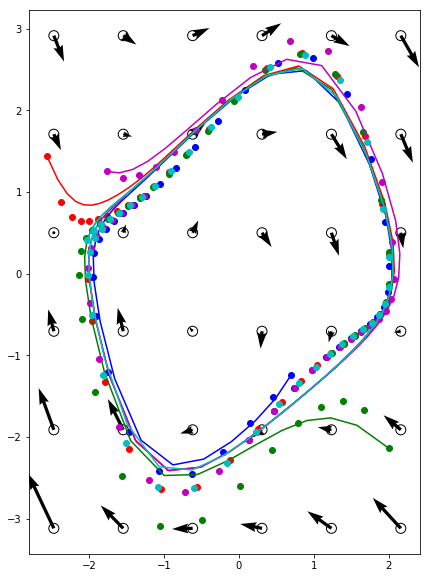

In [127]:
# plotting
xode = torch.zeros_like(Xt)
for row in range(Xt.size()[0]):
    xode[row,:,:] = odeint(net, x0[row], t)
xode = xode.detach().numpy()
# xode = np.transpose(xode,[1,0,2])
U = np.zeros(Zt.size())
for row in range(U.shape[0]):
    U[row,:] = net(t, Zt[row,:]).detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Inference using Sampling Algorithms

In [65]:
from samplers.metrics import *



bayesian_net = NN(input_size=D, hidden_size=20)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, a=-0.5, b=0.5)

bayesian_net.apply(init_normal)

def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(bayesian_closure(), bayesian_net.parameters(), create_graph=True), bayesian_net.parameters())
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess

itr = 0
reg=0.5

def bayesian_closure(add_prior=True):
    global itr
    T   = min(3+itr//10, len(t))
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(bayesian_net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in bayesian_net.parameters()])
    return loss

def psgld_closure(add_prior=True):
    global itr
    T   = min(3+itr//10, len(t))
#     T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(bayesian_net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in bayesian_net.parameters()])
    return loss/N


params = bayesian_net.parameters()

# ### Computimng size of full hessian #####
# cnt = 0
# loss_grad = torch.autograd.grad(bayesian_closure(), bayesian_net.parameters(), retain_graph=True)
# print(bayesian_net.parameters, bayesian_net.parameters(), params)
# print(list(bayesian_net.parameters()))
# ####### TODO: Some problem with above line: needing retain_graph=True even when provided 
# for g in loss_grad:
#     g_vector = g.contiguous().view(-1) if cnt == 0\
#                 else torch.cat([g_vector, g.contiguous().view(-1)])
#     cnt = 1
# l = g_vector.size(0)
# ########################################

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
# metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)

In [66]:
from samplers import MALA, SGLD, MMALA, pSGLD

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)

# chain, logp_array = sampler.sample(bayesian_closure, burn_in=200, num_samples=200, print_loss=True)

sampler = pSGLD(params, lr0=0.01, lr_gamma=0.55, lr_t0=100, lr_alpha=1, lambda_=1e-8, alpha=0.99)
chain, logp_array = sampler.sample(psgld_closure, burn_in=1000, num_samples=1000, print_loss=True)

<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 7.666468
Burn-in iter 0002 | loss 5.888474
Burn-in iter 0003 | loss 6.533131
Burn-in iter 0004 | loss 8.324300
Burn-in iter 0005 | loss 10.155661
Burn-in iter 0006 | loss 29.241080
Burn-in iter 0007 | loss 25.717666
Burn-in iter 0008 | loss 20.352566
Burn-in iter 0009 | loss 21.549779
Burn-in iter 0010 | loss 21.731049
Burn-in iter 0011 | loss 39.975791
Burn-in iter 0012 | loss 29.828420
Burn-in iter 0013 | loss 28.626931
Burn-in iter 0014 | loss 24.295554
Burn-in iter 0015 | loss 19.526773
Burn-in iter 0016 | loss 26.302330
Burn-in iter 0017 | loss 22.002284
Burn-in iter 0018 | loss 15.893067
Burn-in iter 0019 | loss 14.552973
Burn-in iter 0020 | loss 15.609609
Burn-in iter 0021 | loss 17.386449
Burn-in iter 0022 | loss 15.339653
Burn-in iter 0023 | loss 16.638720
Burn-in iter 0024 | loss 17.801633
Burn-in iter 0025 | loss 13.068086
Burn-in iter 0026 | loss 14.607276
Burn-in iter 0027 | loss 14.620824
Burn-in iter 0028 | lo

Burn-in iter 0232 | loss 189.645003
Burn-in iter 0233 | loss 189.355810
Burn-in iter 0234 | loss 190.089588
Burn-in iter 0235 | loss 192.389186
Burn-in iter 0236 | loss 192.025192
Burn-in iter 0237 | loss 188.289540
Burn-in iter 0238 | loss 186.961502
Burn-in iter 0239 | loss 187.235619
Burn-in iter 0240 | loss 187.338626
Burn-in iter 0241 | loss 187.343229
Burn-in iter 0242 | loss 188.305502
Burn-in iter 0243 | loss 187.401664
Burn-in iter 0244 | loss 184.667538
Burn-in iter 0245 | loss 184.520696
Burn-in iter 0246 | loss 188.018291
Burn-in iter 0247 | loss 187.195223
Burn-in iter 0248 | loss 185.741621
Burn-in iter 0249 | loss 183.210478
Burn-in iter 0250 | loss 181.156319
Burn-in iter 0251 | loss 180.679187
Burn-in iter 0252 | loss 180.146708
Burn-in iter 0253 | loss 179.645253
Burn-in iter 0254 | loss 178.445469
Burn-in iter 0255 | loss 179.870423
Burn-in iter 0256 | loss 179.852762
Burn-in iter 0257 | loss 180.543543
Burn-in iter 0258 | loss 177.884840
Burn-in iter 0259 | loss 179

Burn-in iter 0460 | loss 122.360652
Burn-in iter 0461 | loss 117.569227
Burn-in iter 0462 | loss 118.944648
Burn-in iter 0463 | loss 119.376338
Burn-in iter 0464 | loss 118.113697
Burn-in iter 0465 | loss 119.220671
Burn-in iter 0466 | loss 116.921532
Burn-in iter 0467 | loss 118.742503
Burn-in iter 0468 | loss 117.607763
Burn-in iter 0469 | loss 117.527410
Burn-in iter 0470 | loss 119.655067
Burn-in iter 0471 | loss 117.100591
Burn-in iter 0472 | loss 119.268207
Burn-in iter 0473 | loss 116.154777
Burn-in iter 0474 | loss 115.326279
Burn-in iter 0475 | loss 116.569428
Burn-in iter 0476 | loss 116.237441
Burn-in iter 0477 | loss 115.786601
Burn-in iter 0478 | loss 117.460533
Burn-in iter 0479 | loss 115.879183
Burn-in iter 0480 | loss 117.898664
Burn-in iter 0481 | loss 119.693375
Burn-in iter 0482 | loss 122.210291
Burn-in iter 0483 | loss 119.658055
Burn-in iter 0484 | loss 118.416555
Burn-in iter 0485 | loss 122.723196
Burn-in iter 0486 | loss 119.471963
Burn-in iter 0487 | loss 118

Burn-in iter 0692 | loss 69.916331
Burn-in iter 0693 | loss 68.603044
Burn-in iter 0694 | loss 66.195058
Burn-in iter 0695 | loss 63.697836
Burn-in iter 0696 | loss 62.611924
Burn-in iter 0697 | loss 63.810008
Burn-in iter 0698 | loss 64.396633
Burn-in iter 0699 | loss 64.549974
Burn-in iter 0700 | loss 63.965491
Burn-in iter 0701 | loss 64.080057
Burn-in iter 0702 | loss 63.787256
Burn-in iter 0703 | loss 67.073761
Burn-in iter 0704 | loss 64.028823
Burn-in iter 0705 | loss 64.847905
Burn-in iter 0706 | loss 63.109130
Burn-in iter 0707 | loss 61.231607
Burn-in iter 0708 | loss 62.364055
Burn-in iter 0709 | loss 64.053969
Burn-in iter 0710 | loss 61.310104
Burn-in iter 0711 | loss 64.084753
Burn-in iter 0712 | loss 61.578275
Burn-in iter 0713 | loss 61.127876
Burn-in iter 0714 | loss 61.664276
Burn-in iter 0715 | loss 61.936617
Burn-in iter 0716 | loss 61.330363
Burn-in iter 0717 | loss 63.950662
Burn-in iter 0718 | loss 64.128438
Burn-in iter 0719 | loss 62.878721
Burn-in iter 0720 | 

Burn-in iter 0927 | loss 57.877106
Burn-in iter 0928 | loss 59.250407
Burn-in iter 0929 | loss 58.294178
Burn-in iter 0930 | loss 109.719191
Burn-in iter 0931 | loss 89.770743
Burn-in iter 0932 | loss 86.319260
Burn-in iter 0933 | loss 82.433210
Burn-in iter 0934 | loss 76.274406
Burn-in iter 0935 | loss 78.416762
Burn-in iter 0936 | loss 76.145443
Burn-in iter 0937 | loss 74.096240
Burn-in iter 0938 | loss 68.770470
Burn-in iter 0939 | loss 68.497548
Burn-in iter 0940 | loss 67.760353
Burn-in iter 0941 | loss 67.693734
Burn-in iter 0942 | loss 67.577546
Burn-in iter 0943 | loss 68.045200
Burn-in iter 0944 | loss 66.656406
Burn-in iter 0945 | loss 66.943983
Burn-in iter 0946 | loss 65.913215
Burn-in iter 0947 | loss 65.472651
Burn-in iter 0948 | loss 66.151081
Burn-in iter 0949 | loss 64.591213
Burn-in iter 0950 | loss 65.119484
Burn-in iter 0951 | loss 65.618667
Burn-in iter 0952 | loss 64.205269
Burn-in iter 0953 | loss 64.393469
Burn-in iter 0954 | loss 63.929243
Burn-in iter 0955 |

Sample iter 0166 | loss 55.707447
Sample iter 0167 | loss 57.500180
Sample iter 0168 | loss 60.223375
Sample iter 0169 | loss 62.990197
Sample iter 0170 | loss 60.247072
Sample iter 0171 | loss 57.626893
Sample iter 0172 | loss 55.783986
Sample iter 0173 | loss 55.164159
Sample iter 0174 | loss 58.046222
Sample iter 0175 | loss 58.996341
Sample iter 0176 | loss 56.755504
Sample iter 0177 | loss 55.465234
Sample iter 0178 | loss 54.967950
Sample iter 0179 | loss 54.619383
Sample iter 0180 | loss 54.748299
Sample iter 0181 | loss 54.338031
Sample iter 0182 | loss 54.305190
Sample iter 0183 | loss 55.477607
Sample iter 0184 | loss 54.483263
Sample iter 0185 | loss 54.733671
Sample iter 0186 | loss 54.214064
Sample iter 0187 | loss 54.631904
Sample iter 0188 | loss 55.114567
Sample iter 0189 | loss 54.618488
Sample iter 0190 | loss 55.007438
Sample iter 0191 | loss 54.522678
Sample iter 0192 | loss 54.092995
Sample iter 0193 | loss 54.534068
Sample iter 0194 | loss 54.689437
Sample iter 01

Sample iter 0407 | loss 54.061653
Sample iter 0408 | loss 51.343612
Sample iter 0409 | loss 54.193384
Sample iter 0410 | loss 52.629266
Sample iter 0411 | loss 52.269052
Sample iter 0412 | loss 51.229189
Sample iter 0413 | loss 50.846846
Sample iter 0414 | loss 55.065954
Sample iter 0415 | loss 54.922143
Sample iter 0416 | loss 54.448427
Sample iter 0417 | loss 50.844227
Sample iter 0418 | loss 51.942747
Sample iter 0419 | loss 50.771594
Sample iter 0420 | loss 52.965876
Sample iter 0421 | loss 53.814593
Sample iter 0422 | loss 53.177480
Sample iter 0423 | loss 53.692874
Sample iter 0424 | loss 51.816783
Sample iter 0425 | loss 52.909927
Sample iter 0426 | loss 57.254018
Sample iter 0427 | loss 53.011954
Sample iter 0428 | loss 51.487510
Sample iter 0429 | loss 55.157725
Sample iter 0430 | loss 52.793243
Sample iter 0431 | loss 52.686108
Sample iter 0432 | loss 51.613409
Sample iter 0433 | loss 51.509065
Sample iter 0434 | loss 51.595689
Sample iter 0435 | loss 57.393765
Sample iter 04

Sample iter 0648 | loss 55.585808
Sample iter 0649 | loss 56.002152
Sample iter 0650 | loss 56.404447
Sample iter 0651 | loss 55.630889
Sample iter 0652 | loss 55.326907
Sample iter 0653 | loss 54.255144
Sample iter 0654 | loss 53.108052
Sample iter 0655 | loss 53.807791
Sample iter 0656 | loss 57.209160
Sample iter 0657 | loss 53.551137
Sample iter 0658 | loss 54.545474
Sample iter 0659 | loss 53.212732
Sample iter 0660 | loss 54.193634
Sample iter 0661 | loss 57.910062
Sample iter 0662 | loss 56.453792
Sample iter 0663 | loss 54.945708
Sample iter 0664 | loss 56.261683
Sample iter 0665 | loss 54.290554
Sample iter 0666 | loss 53.814177
Sample iter 0667 | loss 53.502635
Sample iter 0668 | loss 54.265568
Sample iter 0669 | loss 53.180177
Sample iter 0670 | loss 53.798136
Sample iter 0671 | loss 53.710825
Sample iter 0672 | loss 53.844495
Sample iter 0673 | loss 53.915175
Sample iter 0674 | loss 54.883654
Sample iter 0675 | loss 56.860166
Sample iter 0676 | loss 56.367773
Sample iter 06

Sample iter 0889 | loss 57.222727
Sample iter 0890 | loss 56.706115
Sample iter 0891 | loss 57.122649
Sample iter 0892 | loss 56.936579
Sample iter 0893 | loss 56.836745
Sample iter 0894 | loss 58.095433
Sample iter 0895 | loss 59.813431
Sample iter 0896 | loss 59.460346
Sample iter 0897 | loss 60.812197
Sample iter 0898 | loss 59.769909
Sample iter 0899 | loss 63.045754
Sample iter 0900 | loss 63.205594
Sample iter 0901 | loss 61.246779
Sample iter 0902 | loss 59.315596
Sample iter 0903 | loss 57.093488
Sample iter 0904 | loss 57.099362
Sample iter 0905 | loss 61.257784
Sample iter 0906 | loss 64.119540
Sample iter 0907 | loss 56.712453
Sample iter 0908 | loss 56.380173
Sample iter 0909 | loss 56.499437
Sample iter 0910 | loss 56.772086
Sample iter 0911 | loss 58.134226
Sample iter 0912 | loss 56.819158
Sample iter 0913 | loss 58.220610
Sample iter 0914 | loss 62.274466
Sample iter 0915 | loss 56.475531
Sample iter 0916 | loss 56.044228
Sample iter 0917 | loss 56.915471
Sample iter 09

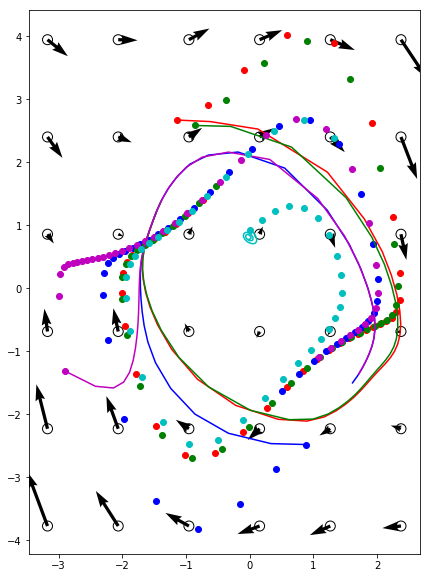

In [67]:
for i, param in enumerate(params):
    param.data = np.mean([sample[0][0][i] for sample in chain[1*len(sample)//10:] if sample[1]], axis=0)
    
# plotting
xode = torch.zeros_like(Xt)
for row in range(Xt.size()[0]):
    xode[row,:,:] = odeint(bayesian_net, x0[row], t)
xode = xode.detach().numpy()
# xode = np.transpose(xode,[1,0,2])
U = np.zeros(Zt.size())
for row in range(U.shape[0]):
    U[row,:] = net(t, Zt[row,:]).detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

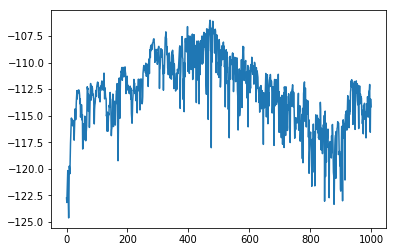

In [68]:
plt.plot(logp_array[1000:])